In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
from scipy import io as spio
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ROOTDIR_DATA = "./ThinkDeep/"

## ResNet18

In [3]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels,
            padding='same',
            kernel_size=3,
            strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels,
            kernel_size=3,
            padding='same')
        self.conv_1x1 = None
        if use_1x1conv:
            self.conv_1x1 = tf.keras.layers.Conv2D(
                num_channels,
                kernel_size=1,
                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv_1x1 is not None:
            X = self.conv_1x1(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, downscale=True,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and downscale:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers:
            X = layer(X)
        return X

class ResNet(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64,
                                    kernel_size=7,
                                    strides=2,
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3,
                                       strides=2,
                                       padding='same')])
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.global_pool(x)
        return self.classifier(x)

# Dataset

In [4]:
(mnist_train, mnist_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def process_data(image, label):
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 10, name='label', axis=-1)

mnist_train = mnist_train.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
mnist_train = mnist_train.cache()
mnist_train = mnist_train.shuffle(ds_info.splits['train'].num_examples)
mnist_train = mnist_train.batch(128)
mnist_train = mnist_train.prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.TWLWFH_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.TWLWFH_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


`tf.data.Dataset` objects can be converted to `pandas.DataFrame` with tfds.as_dataframe to be visualized on Colab.

N.B. Do not shuffle test dataset

In [5]:
mnist_test = mnist_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
mnist_test = mnist_test.cache()
mnist_test = mnist_test.batch(128)
mnist_test = mnist_test.prefetch(tf.data.AUTOTUNE)

# **Assignment #1**: Train and test on MNIST

In [6]:
#checkpoint_dir = "/content/drive/MyDrive/ColabNotebooks/MLA_Course_old/resnet_mnist"
#checkpoint_path = os.path.join(checkpoint_dir, "resnet_mnist.weights.h5")
#os.makedirs(checkpoint_dir, exist_ok=True)

In [7]:
net = ResNet()
net.build((1, 28, 28, 1))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

net.fit(mnist_train, epochs=3)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'res_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.3636 - loss: 2.1023
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8914 - loss: 0.3440
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9496 - loss: 0.1600


In [8]:
test_loss, test_acc = net.evaluate(mnist_test)
print(f"Test Accuracy: {test_acc:.2f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9579 - loss: 0.1248
Test Accuracy: 0.96


# Uncertainty in DL - MC Dropout


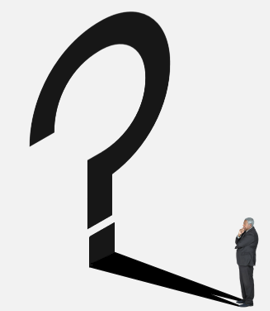

## **Assignment #2**: Code a MC Dropout-based version of ResNet18

In [9]:
class ResNetMC(tf.keras.Model):

    def __init__(self, num_classes=10, mc_dropout=None):
        super(ResNetMC, self).__init__()
        self.mc_dropout = mc_dropout
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64,
                                    kernel_size=7,
                                    strides=2,
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3,
                                       strides=2,
                                       padding='same')])
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")
        # Initialize Dropout layers outside the call method
        if self.mc_dropout:
            self.dropout_layers = [
                tf.keras.layers.Dropout(self.mc_dropout),  # For block_a
                tf.keras.layers.Dropout(self.mc_dropout),  # For block_b
                tf.keras.layers.Dropout(self.mc_dropout),  # For block_c
                tf.keras.layers.Dropout(self.mc_dropout),  # For block_d
                tf.keras.layers.Dropout(self.mc_dropout)   # For block_e
            ]
        else:
            self.dropout_layers = []

    def call(self, inputs, training=False):
        x = self.block_a(inputs)
        if self.mc_dropout:
          x = self.dropout_layers[0](x, training=training) # Use pre-initialized Dropout layer
        x = self.block_b(x)
        if self.mc_dropout:
          x = self.dropout_layers[1](x, training=training) # Use pre-initialized Dropout layer
        x = self.block_c(x)
        if self.mc_dropout:
          x = self.dropout_layers[2](x, training=training) # Use pre-initialized Dropout layer
        x = self.block_d(x)
        if self.mc_dropout:
          x = self.dropout_layers[3](x, training=training) # Use pre-initialized Dropout layer
        x = self.block_e(x)
        if self.mc_dropout:
          x = self.dropout_layers[4](x, training=training) # Use pre-initialized Dropout layer
        x = self.global_pool(x)
        return self.classifier(x)

## Load EMNIST

In [10]:
def show_images_from_npy(array, cmap=None):
    fig, ax = plt.subplots(1, 5)
    ax = ax.ravel()
    j = 0
    for idx in np.random.randint(0, array.shape[0], 5):
        ax[j].imshow(array[idx], cmap=cmap)
        ax[j].axis('off')
        j += 1
emnist = np.load(os.path.join(ROOTDIR_DATA, "emnist_images.npy"))
emnist_numpy = (emnist / 255).astype(np.float32)

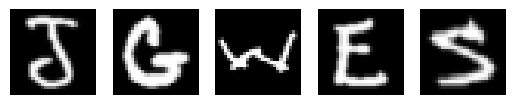

In [11]:
show_images_from_npy(emnist_numpy, cmap="gray")

N.B. Do not shuffle emnist

In [12]:
emnist = np.load(os.path.join(ROOTDIR_DATA, "emnist_images.npy"))
emnist_numpy = (emnist / 255).astype(np.float32)
emnist_numpy = np.expand_dims(emnist_numpy, axis=-1)
print("emnist shape:", emnist_numpy.shape)


emnist shape: (10000, 28, 28, 1)


## **Assignment #3**: Code a wrapper for a MC-based network
Implements:
1.   Several metrics to compute uncertainty
2.   Method to reierate predictions


In [13]:
class UncertaintyWrapper(tf.keras.Model):
    def __init__(self, num_classes=10, mc_dropout=None):
        super(UncertaintyWrapper, self).__init__()
        print(f"MC Dropout is set to {mc_dropout}")
        self.model = ResNetMC(mc_dropout=mc_dropout)
        self._uncertainty_metrics = {
            'entropy': self._entropy,
            'variance': self._variance,
            'max_softmax_response': self._max_softmax_response
        }

    def call(self, inputs):
        return self.model(inputs)

    def uncertainty_metrics(self, multiple_preds):
        """
        multiple_preds can be:
        - shape (draws, batch, num_classes): for MC dropout
        - shape (batch, num_classes): for deterministic prediction
        """
        # If the shape is 2D, expand it to 3D as if it's a single draw.
        if len(multiple_preds.shape) == 2:
            multiple_preds = tf.expand_dims(multiple_preds, axis=0)

        results = {}
        for metric_name, metric_fn in self._uncertainty_metrics.items():
            print(f"Computing {metric_name}...")
            unc_value = metric_fn(multiple_preds)  # raw calculation (unnormalized)
            unc_value = self._normalize(unc_value)  # normalization
            results[metric_name] = unc_value
        return results

    def predict_many_times(self, inputs, draws=2):
        """
        Performs multiple forward passes (with training=True) for MC Dropout.
        If inputs is a tf.data.Dataset, concatenates the batches into a single tensor.
        Returns a tensor of shape (draws, batch, num_classes).
        """
        # If the input is a tf.data.Dataset, extract the images and concatenate them.
        if isinstance(inputs, tf.data.Dataset):
            inputs = inputs.map(lambda x, y: x)  # take only images
            inputs = tf.concat(list(inputs), axis=0)

        preds_list = []
        for _ in range(draws):
            # Forward pass with dropout enabled
            preds_list.append(self.model(inputs, training=True))
        # Stack along axis 0 to obtain a tensor of shape (draws, batch, num_classes)
        return tf.stack(preds_list, axis=0)

    def _average_prediction(self, multiple_preds):
        """
        Computes the average of the predictions along axis 0 (draws).
        multiple_preds: tensor of shape (draws, batch, num_classes).
        Returns a tensor of shape (batch, num_classes).
        """
        return tf.reduce_mean(multiple_preds, axis=0)

    def _entropy(self, multiple_preds):
        """
        Computes the entropy from the averaged predictions:
        -sum(p * log(p)) for each sample.
        """
        avg_preds = self._average_prediction(multiple_preds)
        return -tf.reduce_sum(avg_preds * tf.math.log(avg_preds + 1e-10), axis=-1)

    def _variance(self, multiple_preds):
        """
        Computes the variance along axis 0 (draws), then averages over the classes (last axis).
        Returns a tensor of shape (batch,).
        """
        # Compute variance per class, then average over the classes
        var_per_draw = tf.math.reduce_variance(multiple_preds, axis=0)
        return tf.reduce_mean(var_per_draw, axis=-1)

    def _max_softmax_response(self, multiple_preds):
        """
        Computes the average predictions over draws,
        then returns the maximum value of the softmax distribution for each sample.
        """
        avg_preds = self._average_prediction(multiple_preds)
        return tf.reduce_max(avg_preds, axis=-1)

    def _normalize(self, values):
        """
        Normalizes the values into the range [0, 1].
        """
        values = tf.cast(values, tf.float32)
        epsilon = 1e-10
        min_val = tf.reduce_min(values)
        max_val = tf.reduce_max(values)
        # Avoid division by zero
        return (values - min_val) / (max_val - min_val + epsilon)


In [14]:
net_unc = UncertaintyWrapper(mc_dropout=0.1)
net_unc.build((1, 28, 28, 1))
net_unc.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net_unc.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
net_unc.fit(mnist_train, epochs=1)
print("Accuracy on test set: {:.2f}".format(net_unc.evaluate(mnist_test)[1]))

MC Dropout is set to 0.1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'uncertainty_wrapper', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "uncertainty_wrapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ res_net_mc (ResNetMC)           │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.3690 - loss: 2.1008
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8912 - loss: 0.3773
Accuracy on test set: 0.89


## Compute MC predicitons and compare with *deterministic* uncertainty computation

In [15]:
# draws=10 => 10 forward pass instead of 1
multiple_preds_emnist = net_unc.predict_many_times(emnist_numpy, draws=10)
multiple_preds_mnist = net_unc.predict_many_times(mnist_test, draws=10)

In [16]:
preds_mnist = net.predict(mnist_test)
preds_emnist = net.predict(emnist_numpy)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [17]:
print("Example of softmax:", preds_mnist[0])
print("Max prob:", np.max(preds_mnist[0]))

Example of softmax: [1.6464072e-06 1.6650720e-05 9.5731157e-01 4.2429388e-02 1.0621386e-05
 1.6432707e-05 1.6079982e-06 3.0672988e-06 7.6604709e-05 1.3243960e-04]
Max prob: 0.9573116


In [18]:
uncertainties = dict()
uncertainties_deterministic = dict()

uncertainties = {
    'mnist': net_unc.uncertainty_metrics(multiple_preds_mnist),
    'emnist': net_unc.uncertainty_metrics(multiple_preds_emnist)
}

uncertainties_deterministic = {
    'mnist': net_unc.uncertainty_metrics(preds_mnist),
    'emnist': net_unc.uncertainty_metrics(preds_emnist)
}

Computing entropy...
Computing variance...
Computing max_softmax_response...
Computing entropy...
Computing variance...
Computing max_softmax_response...
Computing entropy...
Computing variance...
Computing max_softmax_response...
Computing entropy...
Computing variance...
Computing max_softmax_response...


In [19]:
uncertainties['mnist'] = net_unc.uncertainty_metrics(multiple_preds_mnist)
uncertainties['emnist'] = net_unc.uncertainty_metrics(multiple_preds_emnist)
uncertainties_deterministic['mnist'] = net_unc.uncertainty_metrics(preds_mnist)
uncertainties_deterministic['emnist'] = net_unc.uncertainty_metrics(preds_emnist)

Computing entropy...
Computing variance...
Computing max_softmax_response...
Computing entropy...
Computing variance...
Computing max_softmax_response...
Computing entropy...
Computing variance...
Computing max_softmax_response...
Computing entropy...
Computing variance...
Computing max_softmax_response...


In [20]:
print("MNIST deterministic entropy (mean):", tf.reduce_mean(uncertainties_deterministic['mnist']['entropy']).numpy())
print("EMNIST deterministic entropy (mean):", tf.reduce_mean(uncertainties_deterministic['emnist']['entropy']).numpy())


MNIST deterministic entropy (mean): 0.084362596
EMNIST deterministic entropy (mean): 0.284592


## **Assignment #4** Uncertainty metrics distributions for MNIST and EMNIST
Plot distributions in form of histograms


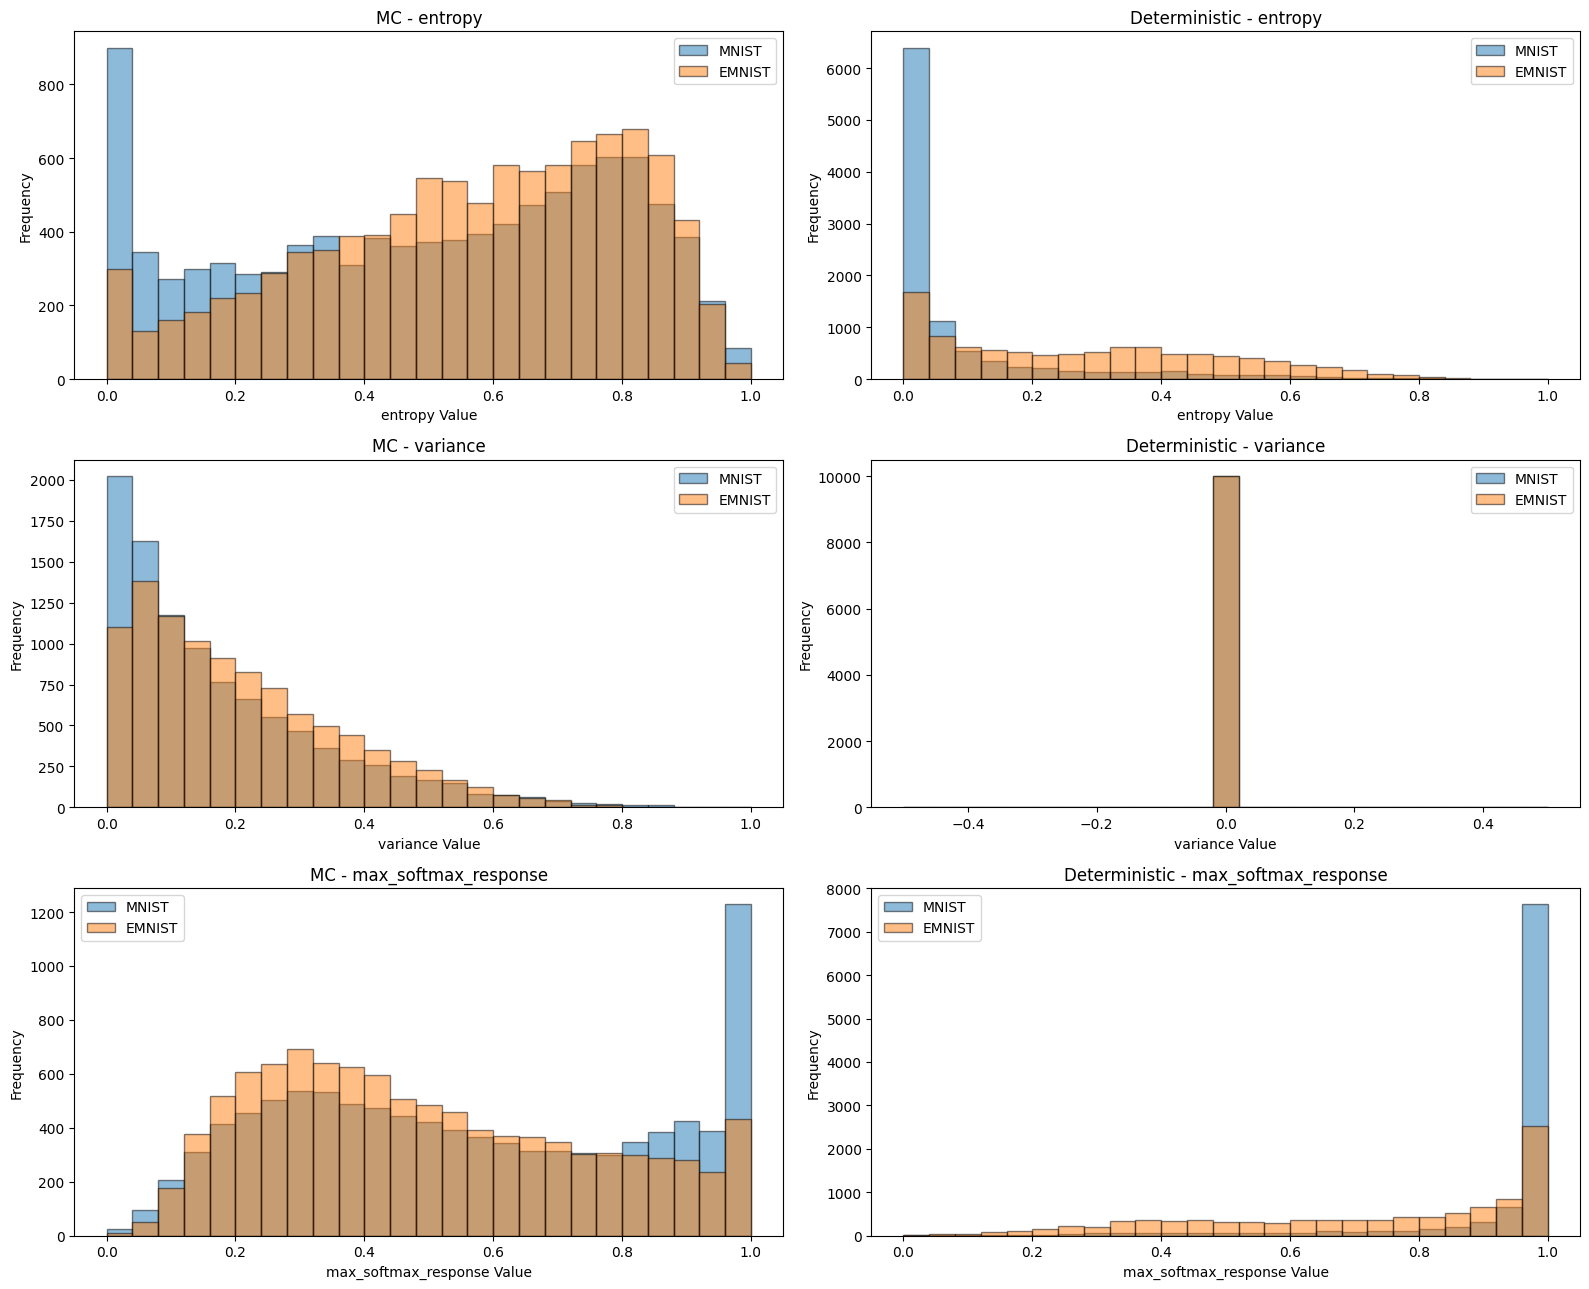

In [21]:
metrics = list(net_unc._uncertainty_metrics.keys())
fig, axes = plt.subplots(len(metrics), 2, figsize=(16, 13))

for i, measure in enumerate(metrics):
    axes[i, 0].set_title(f"MC - {measure}")
    axes[i, 0].hist(uncertainties['mnist'][measure].numpy(), bins=25, alpha=0.5, label="MNIST", edgecolor='black')
    axes[i, 0].hist(uncertainties['emnist'][measure].numpy(), bins=25, alpha=0.5, label="EMNIST", edgecolor='black')
    axes[i, 0].legend()
    axes[i, 0].set_xlabel(f'{measure} Value')
    axes[i, 0].set_ylabel('Frequency')

    axes[i, 1].set_title(f"Deterministic - {measure}")
    axes[i, 1].hist(uncertainties_deterministic['mnist'][measure].numpy(), bins=25, alpha=0.5, label="MNIST", edgecolor='black')
    axes[i, 1].hist(uncertainties_deterministic['emnist'][measure].numpy(), bins=25, alpha=0.5, label="EMNIST", edgecolor='black')
    axes[i, 1].legend()
    axes[i, 1].set_xlabel(f'{measure} Value')
    axes[i, 1].set_ylabel('Frequency')



plt.tight_layout()
plt.show()


## **Assignment #5** Take a look at confident and not-confident predictions for EMNIST
Filter confident and not-confident images based on uncertainty values and plot some of them

N. confident samples (MC) : 993
N. not confident samples (MC): 1965


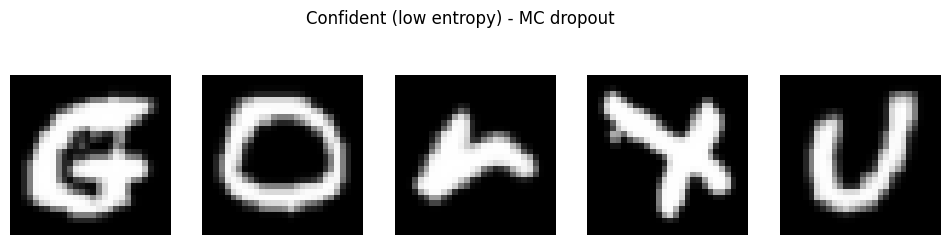

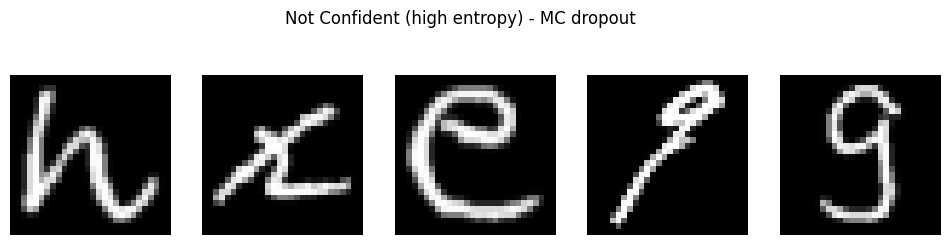

In [22]:

entropies_det = uncertainties_deterministic['emnist']['entropy'].numpy()
entropies_mc = uncertainties['emnist']['entropy'].numpy()

threshold_low = 0.2  # Soglia di entropia sotto cui consideriamo "molto confidente"
threshold_high = 0.8 # Soglia sopra cui consideriamo "molto incerta"

confident_idx = np.where(entropies_mc < threshold_low)[0]
not_confident_idx = np.where(entropies_mc > threshold_high)[0]

print("N. confident samples (MC) :", len(confident_idx))
print("N. not confident samples (MC):", len(not_confident_idx))

def plot_samples(idx_list, title=""):
    fig, axs = plt.subplots(1, 5, figsize=(12,3))
    for i, ax in enumerate(axs):
        if i < len(idx_list):
            ax.imshow(emnist_numpy[idx_list[i]].squeeze(), cmap='gray')
            ax.axis('off')
    fig.suptitle(title)
    plt.show()

plot_samples(confident_idx[:5], title="Confident (low entropy) - MC dropout")
plot_samples(not_confident_idx[:5], title="Not Confident (high entropy) - MC dropout")


# Uncertainty in DL - Ensamble

In [23]:
nets = []
for i in range(3):
    net_ens = ResNet()
    net_ens.build((1, 28, 28, 1))
    opt_ens = tf.keras.optimizers.SGD(learning_rate=0.01)
    net_ens.compile(optimizer=opt_ens, loss="categorical_crossentropy", metrics=["accuracy"])
    print(f"Training ensemble model {i+1}...")
    net_ens.fit(mnist_train, epochs=3)
    nets.append(net_ens)

print("Ensemble models trained.")


Training ensemble model 1...
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'res_net_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.3386 - loss: 2.1477
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8837 - loss: 0.3652
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9489 - loss: 0.1620
Training ensemble model 2...
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'res_net_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.4031 - loss: 2.0974
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9003 - loss: 0.3233
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9496 - loss: 0.1655
Training ensemble model 3...
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'res_net_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.3804 - loss: 2.0906
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8886 - loss: 0.3543
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9477 - loss: 0.1650
Ensemble models trained.


In [24]:
# Eseguiamo la predizione di ciascun modello su EMNIST e MNIST,
# poi calcoliamo le metriche di incertezza usando il nostro wrapper 'net_unc'.

emnist_preds_ensemble = []
mnist_preds_ensemble = []

for i, net_ens in enumerate(nets):
    emnist_preds_ensemble.append(net_ens.predict(emnist_numpy))
    mnist_preds_ensemble.append(net_ens.predict(mnist_test))

# Convertiamo le liste in array di shape (n_modelli, batch, num_classi)
emnist_preds_ensemble = np.array(emnist_preds_ensemble)
mnist_preds_ensemble = np.array(mnist_preds_ensemble)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [41]:
# Add the following lines before line 21 of ipython-input-34-1446d9d37603
# Initialize an empty dictionary for uncertainties_ensable if it doesn't exist
uncertainties_ensable = {}
# assuming net_unc was used to compute the ensemble prediction, adapt this to your use case
uncertainties_ensable['mnist'] = net_unc.uncertainty_metrics(mnist_preds_ensemble)
uncertainties_ensable['emnist'] = net_unc.uncertainty_metrics(emnist_preds_ensemble)

Computing entropy...
Computing variance...
Computing max_softmax_response...
Computing entropy...
Computing variance...
Computing max_softmax_response...


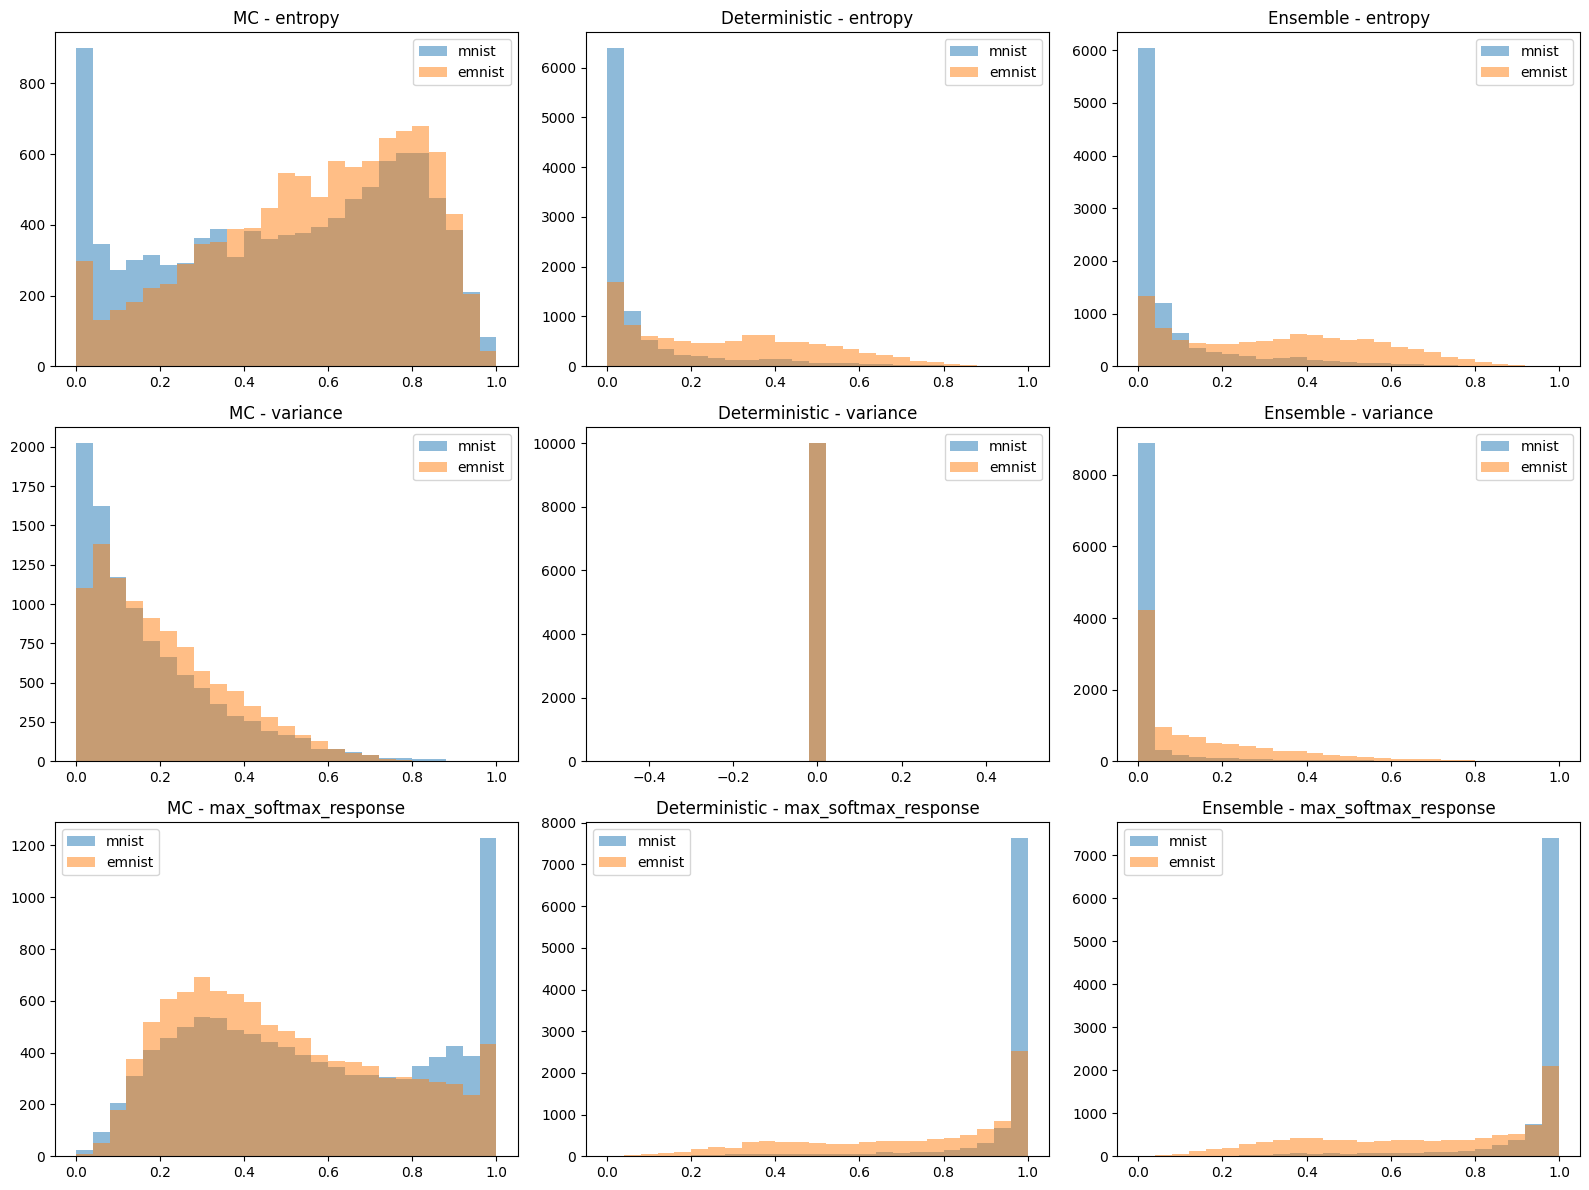

In [42]:
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 3, figsize=(16, 12))

metric_list = list(net_unc._uncertainty_metrics.keys())

for i, measure in enumerate(metric_list):
    axes[i, 0].set_title(f"MC - {measure}")
    axes[i, 0].hist(uncertainties['mnist'][measure].numpy(), bins=25, alpha=0.5, label="mnist")
    axes[i, 0].hist(uncertainties['emnist'][measure].numpy(), bins=25, alpha=0.5, label="emnist")
    axes[i, 0].legend()

    axes[i, 1].set_title(f"Deterministic - {measure}")
    axes[i, 1].hist(uncertainties_deterministic['mnist'][measure].numpy(), bins=25, alpha=0.5, label="mnist")
    axes[i, 1].hist(uncertainties_deterministic['emnist'][measure].numpy(), bins=25, alpha=0.5, label="emnist")
    axes[i, 1].legend()

    axes[i, 2].set_title(f"Ensemble - {measure}")
    axes[i, 2].hist(uncertainties_ensemble['mnist'][measure].numpy(), bins=25, alpha=0.5, label="mnist")
    axes[i, 2].hist(uncertainties_ensemble['emnist'][measure].numpy(), bins=25, alpha=0.5, label="emnist")
    axes[i, 2].legend()

plt.tight_layout()
plt.show()


In [43]:
import tensorflow_probability as tfp
#
tfd = tfp.distributions
NUM_TRAIN_EXAMPLES = 50000
NUM_CLASSES = 10
LR = 0.01

# Uncertainty in DL - Variational Inference

In [44]:
class ResidualVI(tf.keras.Model):
    """The Residual block of ResNet."""

    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /
                                       tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))
        self.conv1 = tfp.layers.Convolution2DFlipout(
            num_channels,
            kernel_size=3,
            padding='same',
            strides=strides,
            kernel_divergence_fn=self.kl_divergence_function,
            activation=tf.nn.relu)
        self.conv2 = tfp.layers.Convolution2DFlipout(
            num_channels,
            kernel_size=3,
            padding='same',
            kernel_divergence_fn=self.kl_divergence_function,
            activation=tf.nn.relu)
        self.conv_1x1 = None
        if use_1x1conv:
            # Replace Conv2D with Convolution2DFlipout for consistency:
            self.conv_1x1 = tfp.layers.Convolution2DFlipout(
                num_channels,
                kernel_size=1,
                strides=strides,
                kernel_divergence_fn=self.kl_divergence_function)

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv_1x1 is not None:
            X = self.conv_1x1(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlockVI(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, downscale=True, **kwargs):
        super(ResnetBlockVI, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and downscale:
                self.residual_layers.append(
                    ResidualVI(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(ResidualVI(num_channels))

    def call(self, X):
        for layer in self.residual_layers:
            X = layer(X)
        return X


class ResNetVI(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(ResNetVI, self).__init__()
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64,
                                    kernel_size=7,
                                    strides=2,
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3,
                                       strides=2,
                                       padding='same')])
        self.block_b = ResnetBlockVI(64, 2, downscale=False)
        self.block_c = ResnetBlockVI(128, 2)
        self.block_d = ResnetBlockVI(256, 2)
        self.block_e = ResnetBlockVI(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.global_pool(x)
        return self.classifier(x)

In [45]:
class VIWrapper(UncertaintyWrapper):
    """Wrapper for variational inference models."""
    def __init__(self, model):
        super().__init__(model)

In [46]:
variational_model = ResNetVI(num_classes=10)
net_vi = VIWrapper(variational_model)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
# The Keras API will automatically add the
# Kullback-Leibler divergence (contained on the individual layers of
# the model), to the cross entropy loss, effectively
# calcuating the (negated) Evidence Lower Bound Loss (ELBO)
net_vi.compile(optimizer, loss='categorical_crossentropy',
               metrics=['accuracy']) # Remove the experimental_run_tf_function argument

net_vi.fit(mnist_train, epochs=3)


MC Dropout is set to None
Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - accuracy: 0.1050 - loss: 49.1193
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1103 - loss: 2.3020
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1108 - loss: 2.3023


In [47]:
print("Accuracy on test set: {:.2f}".format(net_vi.evaluate(mnist_test)[1]))
preds_mnist = net_vi.predict(mnist_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1113 - loss: 2.3021
Accuracy on test set: 0.11
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


In [48]:
vi_preds_emnist = net_vi.predict_many_times(emnist, draws=10)
vi_preds_mnist = net_vi.predict_many_times(mnist_test, draws=10)

In [49]:
uncertainties_vi = dict()
uncertainties_vi['mnist'] = net_unc.uncertainty_metrics(np.array(vi_preds_mnist))
uncertainties_vi['emnist'] = net_unc.uncertainty_metrics(np.array(vi_preds_emnist))

Computing entropy...
Computing variance...
Computing max_softmax_response...
Computing entropy...
Computing variance...
Computing max_softmax_response...


KeyboardInterrupt: 

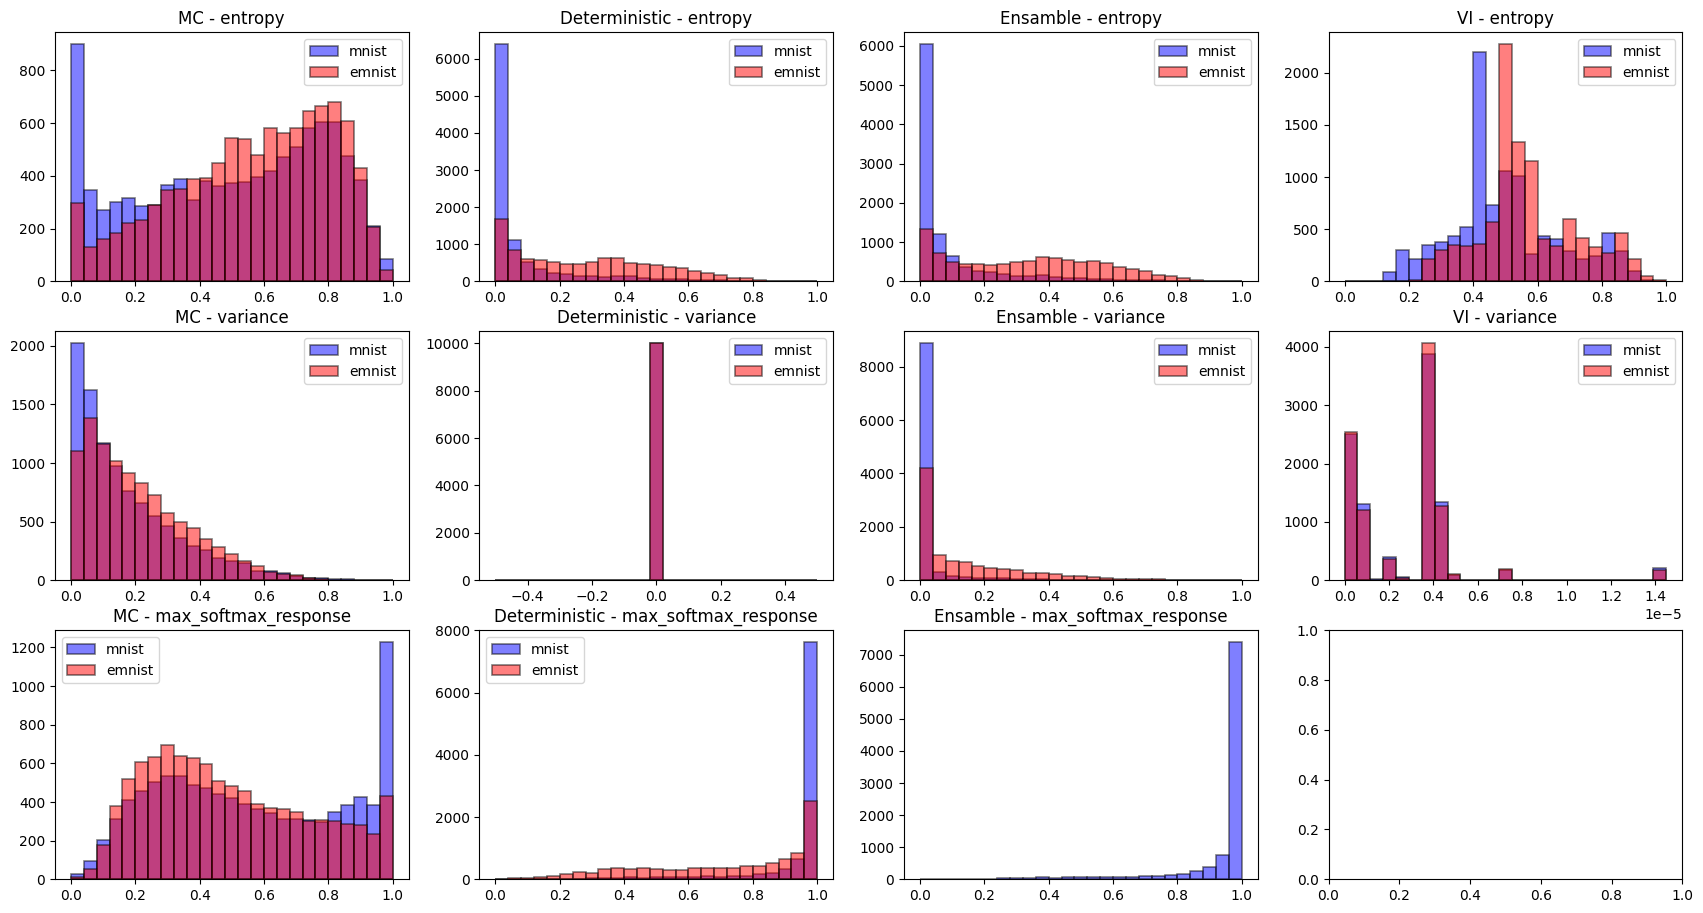

In [50]:
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 4, figsize=(21, 11))
for ax, measure in zip(axes, net_unc._uncertainty_metrics.keys()):
    ax[0] .set_title(f"MC - {measure}")
    ax[0].hist(uncertainties['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[0].hist(uncertainties['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[0].legend()
    ax[1] .set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties_deterministic['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[1].hist(uncertainties_deterministic['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[1].legend()
    ax[2] .set_title(f"Ensamble - {measure}")
    ax[2].hist(uncertainties_ensable['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[2].hist(uncertainties_ensable['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[2].legend()
    ax[3] .set_title(f"VI - {measure}")
    ax[3].hist(uncertainties_vi['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[3].hist(uncertainties_vi['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[3].legend()
plt.tight_layout()

# Uncertainty in DL - Test Time Augmentation-Based
See [data augmentation for tensorflow and keras](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [55]:
class TTAWrapper(UncertaintyWrapper):
    def __init__(self, num_classes=10):
        super(TTAWrapper, self).__init__()
        self.model = ResNet()
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def call(self, inputs):
        return self.model(inputs)

    def predict_many_times(self, ds, policy, repeat=1):
        pred_augmented = list()

        policy_random_crop = [
            tf.keras.Sequential([
                tf.keras.layers.RandomCrop(15, 15),
                tf.keras.layers.Resizing(28, 28)])]

        policy_random_flip = [
            tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal")])
        ]

        policy_random_contrast = [
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.3, 0.3)])
        ]

        policy_random_zoom = [
            tf.keras.Sequential([
                tf.keras.layers.RandomZoom(0.3)])
        ]

        policy_identity = [tf.keras.Sequential([
            tf.keras.layers.Layer()])]

        policies = dict()
        policies['identity'] = policy_identity
        policies['random_crop'] = policy_random_crop
        policies['random_contrast'] = policy_random_contrast
        policies['random_zoom'] = policy_random_zoom
        policies['random_flip'] = policy_random_flip

        policies['random_crop'] = sum([policies['random_crop'] for _ in range(repeat)], [])
        policies['random_contrast'] = sum([policies['random_contrast'] for _ in range(repeat)], [])
        policies['random_zoom'] = sum([policies['random_zoom'] for _ in range(repeat)], [])
        policies['random_flip'] = sum([policies['random_flip'] for _ in range(repeat)], [])

        # Check if ds is a NumPy array and convert it to a tf.data.Dataset if needed
        if isinstance(ds, np.ndarray):
            # Assuming ds is images only, create a dummy label dataset
            labels = tf.zeros(ds.shape[0], dtype=tf.int64)
            ds = tf.data.Dataset.from_tensor_slices((ds, labels)).batch(128)  # adjust batch size as needed

        for p in policies[policy]:
            ds_augmented = ds.map(lambda x, y: (p(x, training=True), y))
            pred_augmented.append(self.predict(ds_augmented))

        return pred_augmented

In [56]:
net_tta = TTAWrapper()
net_tta.build((1, 28, 28, 1))
net_tta.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net_tta.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
net_tta.fit(mnist_train, epochs=3)
print("Accuracy on test set: {:.2f}".format(net_tta.evaluate(mnist_test)[1]))

MC Dropout is set to None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'tta_wrapper_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "tta_wrapper_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ res_net_mc_6 (ResNetMC)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_7 (ResNet)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.3642 - loss: 2.0923
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9021 - loss: 0.3188
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9523 - loss: 0.1523
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9483 - loss: 0.1665
Accuracy on test set: 0.95


In [57]:
emnist_preds_tta = net_tta.predict_many_times(emnist, "random_zoom", repeat=10)
mnist_preds_tta = net_tta.predict_many_times(mnist_test, "random_zoom", repeat=10)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Computing entropy...
Computing variance...
Computing max_softmax_response...
Computing entropy...
Computing variance...
Computing max_softmax_response...


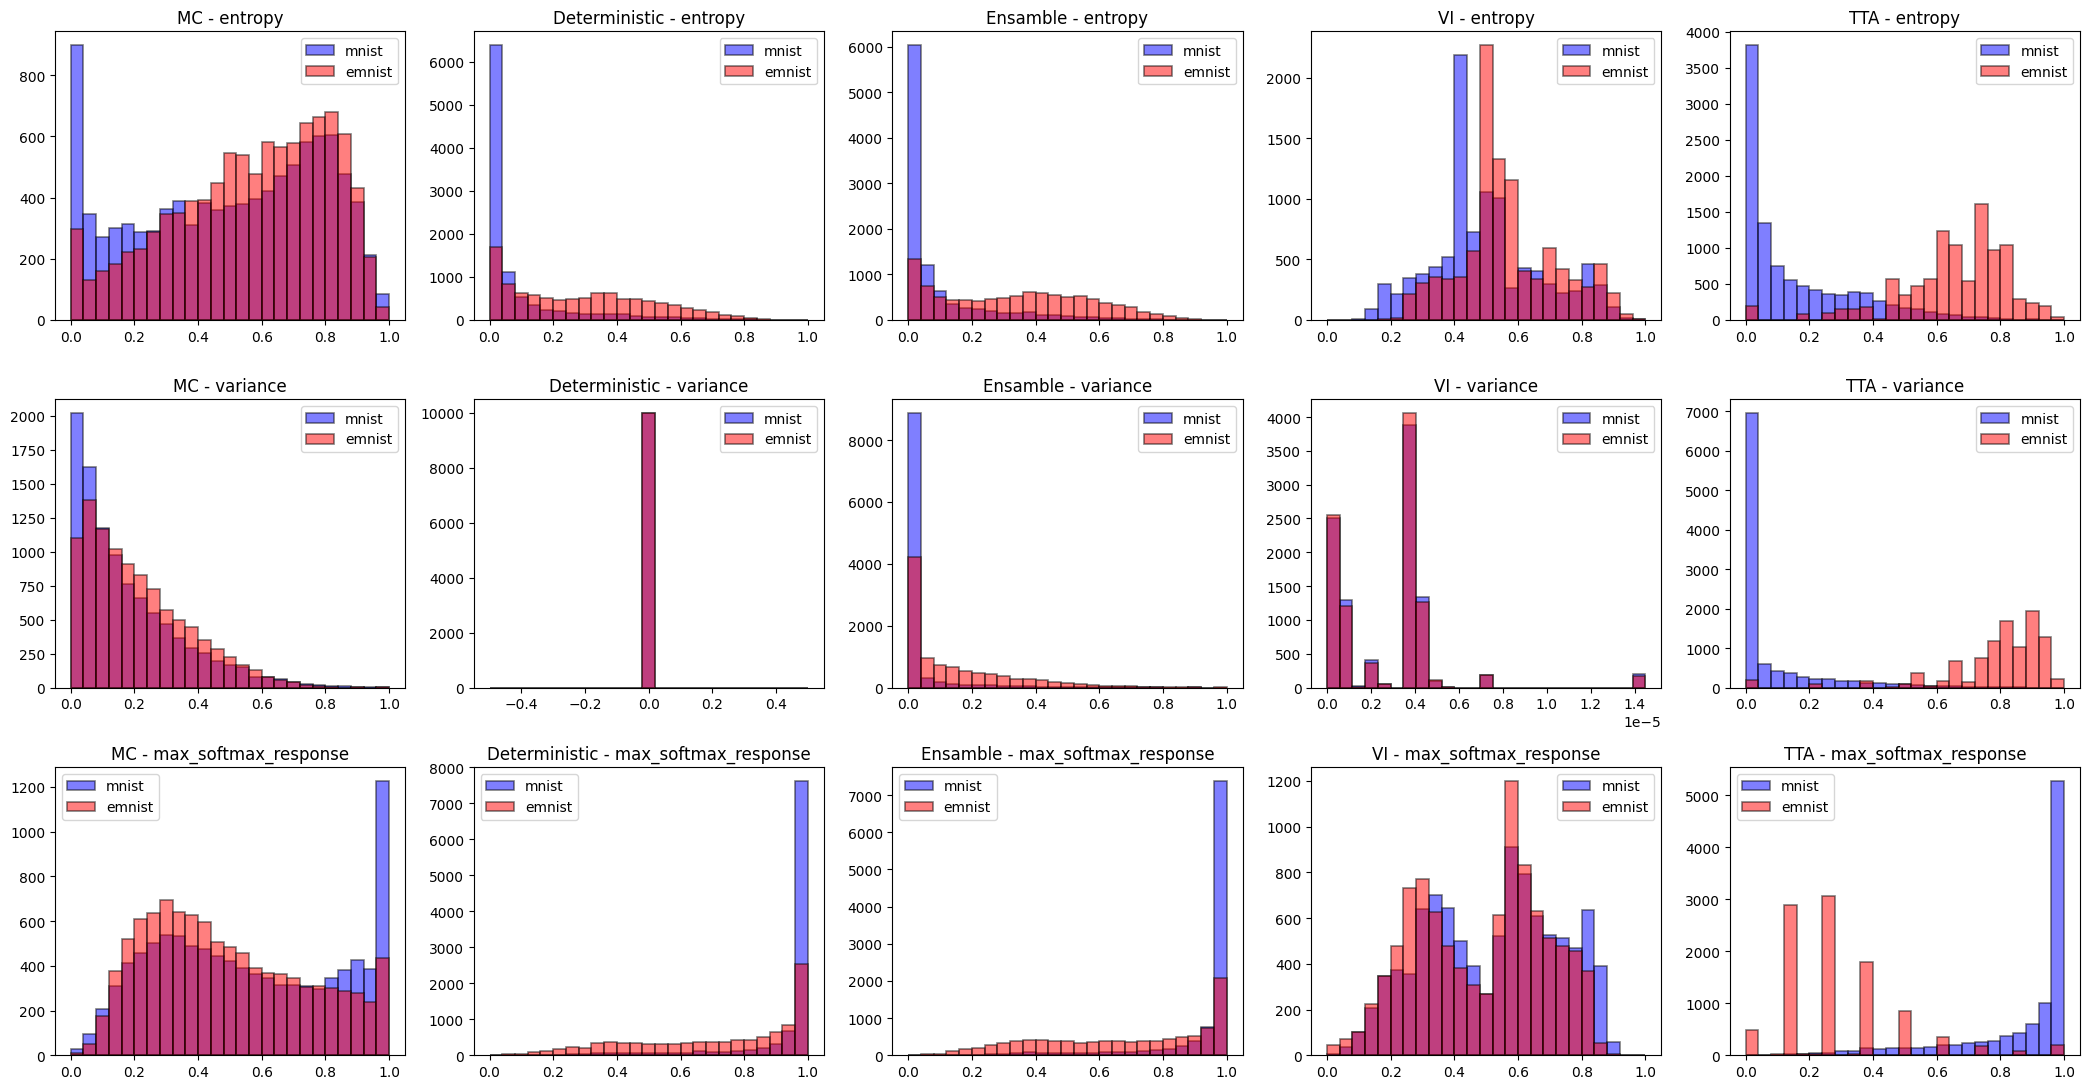

In [58]:
uncertainties_tta = dict()
uncertainties_tta['mnist'] = net_tta.uncertainty_metrics(np.array(mnist_preds_tta))
uncertainties_tta['emnist'] = net_tta.uncertainty_metrics(np.array(emnist_preds_tta))
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 5, figsize=(21, 11))
for ax, measure in zip(axes, net_unc._uncertainty_metrics.keys()):
    ax[0].set_title(f"MC - {measure}")
    ax[0].hist(uncertainties['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[0].hist(uncertainties['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[0].legend()
    ax[1] .set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties_deterministic['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[1].hist(uncertainties_deterministic['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[1].legend()
    ax[2].set_title(f"Ensamble - {measure}")
    ax[2].hist(uncertainties_ensable['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[2].hist(uncertainties_ensable['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[2].legend()
    ax[3].set_title(f"VI - {measure}")
    ax[3].hist(uncertainties_vi['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[3].hist(uncertainties_vi['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[3].legend()
    ax[4].set_title(f"TTA - {measure}")
    ax[4].hist(uncertainties_tta['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[4].hist(uncertainties_tta['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[4].legend()
plt.tight_layout()